# Tutorial 1: Simulated Spatially Resolved Paired Multi-Omics Data

We  simulated a spatially resolved multi-omics dataset from mouse visual cortex STARmap spatial transcriptomics data, which consists of 1207 cells annotated by six layer labels:  L1, L2/3, L4, L5, L6, and HPC/CC. We generated two datasets (termed as “Omics-1” and “Omics-2” ) by shuffling cells in L4/L5 and L5/L6, respectively, and then added Gaussian noise to the expression values. We applied COSMOS to integrate the two datasets and evaluated its performance.

The raw data can be downloaded from: 
https://www.dropbox.com/sh/f7ebheru1lbz91s/AADm6D54GSEFXB1feRy6OSASa/visual_1020/20180505_BY3_1kgenes?dl=0&subfolder_nav_tracking=1

The processed data is available at: https://zenodo.org/records/13932144

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import seaborn as sns
from COSMOS import cosmos
from COSMOS.pyWNN import pyWNN 
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

/Applications/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation of data

### Importing the spatially resolved transcriptomics data

In [2]:
# Importing mouse visual cortex STARMap data
df_data = pd.read_csv('./MVC_counts.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./MVC_meta.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_pixels = df_meta.iloc[:,2:4]
df_labels = list(df_meta.iloc[:,1])
adata = sc.AnnData(X = df_data)
adata.obs['LayerName'] = df_labels # Combining HPC and CC
adata.obs['LayerName_2'] = list(df_meta.iloc[:,4]) # Separating HPC and CC

# Spatial positions
adata.obsm['spatial'] = np.array(df_pixels)
adata.obs['x_pos'] = adata.obsm['spatial'][:,0]
adata.obs['y_pos'] = adata.obsm['spatial'][:,1]
label_type = ['L1','L2/3','L4','L5','L6','HPC/CC']

### Generating simulated spatially resolved paired multi-omics data

In [3]:
# Shuffling L4/L5 and L5/L6 of the original data, respectively.
index_all = [np.array([i for i in range(len(df_labels)) if df_labels[i] == label_type[0]])]
for k in range(1,len(label_type)):
    temp_idx = np.array([i for i in range(len(df_labels)) if df_labels[i] == label_type[k]])
    index_all.append(temp_idx)
index_int1 = np.array(list(index_all[2]) + list(index_all[3]))
index_int2 = np.array(list(index_all[4]) + list(index_all[3]))

# Adding Gaussian noise to each omics
adata1 = adata.copy()
np.random.seed(random_seed)
data_noise_1 = 1 + np.random.normal(0,0.05,adata.shape)
adata1.X[index_int1,:] = np.multiply(adata.X,data_noise_1)[np.random.permutation(index_int1),:]

adata2 = adata.copy()
np.random.seed(random_seed+1)
data_noise_2 = 1 + np.random.normal(0,0.05,adata.shape)
adata2.X[index_int2,:] = np.multiply(adata.X,data_noise_2)[np.random.permutation(index_int2),:]

## Applying COSMOS to integrate the two omics

In [4]:
# COSMOS integration
cosmos_comb = cosmos.Cosmos(adata1=adata1,adata2=adata2)
cosmos_comb.preprocessing_data(n_neighbors = 10)
cosmos_comb.train(spatial_regularization_strength=0, z_dim=50, 
         lr=1e-3, wnn_epoch = 500, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
         random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)

Epoch 1/1000, Loss: 1.381675362586975
Epoch 11/1000, Loss: 1.3659112453460693
Epoch 21/1000, Loss: 1.2809498310089111
Epoch 31/1000, Loss: 0.9700765013694763
Epoch 41/1000, Loss: 0.5997390747070312
Epoch 51/1000, Loss: 0.35201629996299744
Epoch 61/1000, Loss: 0.21895653009414673
Epoch 71/1000, Loss: 0.13471603393554688
Epoch 81/1000, Loss: 0.12116068601608276
Epoch 91/1000, Loss: 0.050545282661914825
Epoch 101/1000, Loss: 0.051060620695352554
Epoch 111/1000, Loss: 0.05818295106291771
Epoch 121/1000, Loss: 0.04157373309135437
Epoch 131/1000, Loss: 0.03906165808439255
Epoch 141/1000, Loss: 0.03377138450741768
Epoch 151/1000, Loss: 0.013441799208521843
Epoch 161/1000, Loss: 0.03021172434091568
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 1207 0.01 seconds elapsed
Selecting top K neighbors
Epoch 171/1000, Loss: 0.027580779045820236
Epoch 181/1000, Lo

array([[-0.05122171,  0.06189891, -0.04163396, ...,  0.01719569,
         0.05247426, -0.04250702],
       [ 0.07194728,  0.07764114, -0.00389794, ...,  0.17378254,
        -0.02433215,  0.04073898],
       [-0.0192323 ,  0.0579871 , -0.02071542, ...,  0.2247437 ,
        -0.04349456,  0.4226941 ],
       ...,
       [-0.00102421, -0.00931375, -0.01174889, ...,  0.24501997,
        -0.02405061,  0.13805324],
       [-0.05110589, -0.01487229, -0.0601284 , ..., -0.08477327,
        -0.02289623,  0.19601536],
       [ 0.04408433,  0.07072768, -0.02176655, ...,  0.09735874,
        -0.0297061 ,  0.17471032]], dtype=float32)

### Domain segmentation by COSMOS integration

In [5]:
def screen_resolution(df_embedding, labels, res_s = 0.1, res_e = 1.0, step = 0.05, methods = 'leiden'):
    max_ari = 0
    opt_res = 0
    rec_ari = []
    rec_res = []
    rec_cluster_num = []
    for res in np.arange(res_s,res_e,step):
        embedding_adata = sc.AnnData(df_embedding)
        sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')
        if methods == 'leiden':
            sc.tl.leiden(embedding_adata, resolution=float(res))
            clusters = list(embedding_adata.obs["leiden"])
        else:
            sc.tl.louvain(embedding_adata, resolution=float(res))
            clusters = list(embedding_adata.obs["louvain"])
        ARI_score = sklearn.metrics.adjusted_rand_score(labels, clusters)
        ARI_score = round(ARI_score, 2)
        cluster_num = len(np.unique(clusters))
        print('res = ' + str(round(res, 2)) + ', ARI = ' + str(ARI_score) + ', Cluster# = ' + str(cluster_num))
        rec_ari.append(ARI_score)
        rec_res.append(res)
        rec_cluster_num.append(cluster_num)
    print('Maximal ARI = ' + str(max(rec_ari)) + ' with res = ' + str(round(rec_res[np.argmax(rec_ari)],2)))
    return rec_ari, rec_res, rec_cluster_num



res = 0.2, ARI = 0.79, Cluster# = 5
res = 0.21, ARI = 0.79, Cluster# = 5
res = 0.22, ARI = 0.79, Cluster# = 5
res = 0.23, ARI = 0.79, Cluster# = 5
res = 0.24, ARI = 0.8, Cluster# = 5
res = 0.25, ARI = 0.8, Cluster# = 5
res = 0.26, ARI = 0.8, Cluster# = 5
res = 0.27, ARI = 0.8, Cluster# = 5
res = 0.28, ARI = 0.8, Cluster# = 5
res = 0.29, ARI = 0.84, Cluster# = 6
res = 0.3, ARI = 0.84, Cluster# = 6
res = 0.31, ARI = 0.74, Cluster# = 6
res = 0.32, ARI = 0.74, Cluster# = 6
res = 0.33, ARI = 0.74, Cluster# = 6
res = 0.34, ARI = 0.74, Cluster# = 6
res = 0.35, ARI = 0.74, Cluster# = 6
res = 0.36, ARI = 0.74, Cluster# = 6
res = 0.37, ARI = 0.7, Cluster# = 6
res = 0.38, ARI = 0.74, Cluster# = 6
res = 0.39, ARI = 0.76, Cluster# = 6
res = 0.4, ARI = 0.75, Cluster# = 6
res = 0.41, ARI = 0.75, Cluster# = 6
res = 0.42, ARI = 0.75, Cluster# = 6
res = 0.43, ARI = 0.75, Cluster# = 6
res = 0.44, ARI = 0.75, Cluster# = 6
res = 0.45, ARI = 0.75, Cluster# = 6
res = 0.46, ARI = 0.75, Cluster# = 6
res = 0.47

(-282.4831346765602, 6759.627661884987, -630.5286230210683, 14490.623535171215)

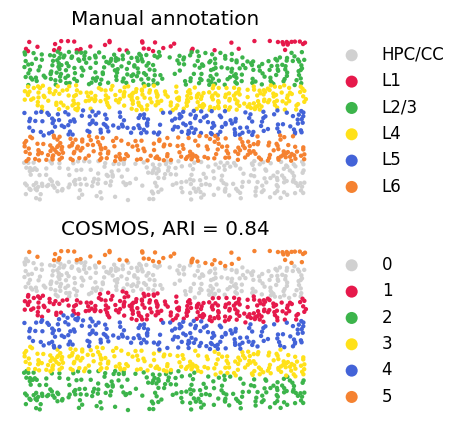

In [6]:
# Obtaining the optimal domain segmentation

adata_new = adata1.copy()
label_annotations = list(adata.obs['LayerName'])

alpha = 0
res_s = 0.2
res_e = 0.5
step = 0.01
methods = 'leiden'
df_embedding = pd.DataFrame(cosmos_comb.embedding)
rec_ari, rec_res, rec_cluster_num = screen_resolution(df_embedding, label_annotations, res_s = res_s, res_e = res_e, step = step, methods = methods)

opt_ari_cosmos = max(rec_ari)
opt_res_cosmos = rec_res[np.argmax(rec_ari)]
embedding_adata = sc.AnnData(df_embedding)
sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')
sc.tl.leiden(embedding_adata, resolution=float(opt_res_cosmos))
opt_clusters_cosmos = list(embedding_adata.obs["leiden"])
adata_new.obs['Cluster_cosmos'] = opt_clusters_cosmos
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(2, 1, figsize=(4,5))
sz = 40
plot_color=['#D1D1D1','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Manual annotation' 
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[0])
ax.axis('off')

domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'COSMOS, ARI = ' + str(opt_ari_cosmos)
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[1])
ax.axis('off')

### UMAP visualization of COSMOS integration

(-8.883453440666198, 14.081739974021911, -6.550229287147522, 8.842858052253723)

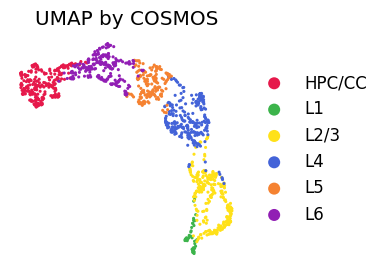

In [7]:
umap_2d = UMAP(n_components=2, init='random', random_state=random_seed, min_dist = 0.3,n_neighbors=30)
umap_pos = umap_2d.fit_transform(df_embedding)
adata_new.obs['cosmos_umap_pos_x'] = umap_pos[:,0]
adata_new.obs['cosmos_umap_pos_y'] = umap_pos[:,1]

matplotlib.rcParams['font.size'] = 12.0
sz = 20
fig, axes = plt.subplots(1, 1, figsize=(3,3))

plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'UMAP by COSMOS' 
ax=sc.pl.scatter(adata_new,alpha=1,x="cosmos_umap_pos_x",y="cosmos_umap_pos_y",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')



### Pseudo-spatiotemporal map (pSM) from COSMOS integration

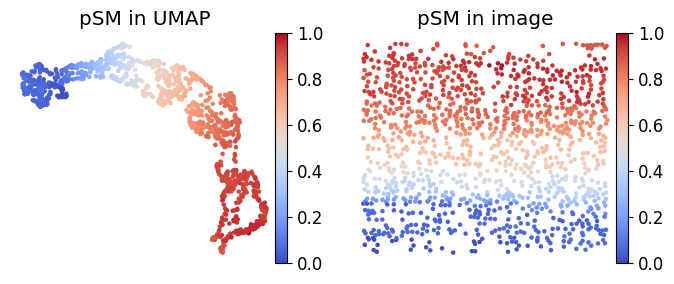

In [8]:
sc.pp.neighbors(embedding_adata, n_neighbors=20, use_rep='X')
# Setting the root to be the first cell in 'HPC' cells
embedding_adata.uns['iroot'] = np.flatnonzero(adata.obs['LayerName_2'] == 'HPC')[0]
# Diffusion map
sc.tl.diffmap(embedding_adata)
# Diffusion pseudotime
sc.tl.dpt(embedding_adata)
pSM_values = embedding_adata.obs['dpt_pseudotime'].to_numpy()

matplotlib.rcParams['font.size'] = 12.0
sz = 20
fig, axes = plt.subplots(1, 2, figsize=(7,3))

x = np.array(adata_new.obs['cosmos_umap_pos_x'])
y = np.array(adata_new.obs['cosmos_umap_pos_y'])
ax_temp = axes[0]
im = ax_temp.scatter(x, y, s=sz, c=pSM_values, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('pSM in UMAP')
fig.colorbar(im, ax = ax_temp,orientation="vertical", pad=-0.01)

x = np.array(adata_new.obs['x_pos'])
y = np.array(adata_new.obs['y_pos'])
ax_temp = axes[1]
im = ax_temp.scatter(x, y, s=sz, c=pSM_values, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('pSM in image')
fig.colorbar(im, ax = ax_temp,orientation="vertical", pad=-0.01)


plt.tight_layout()


### Showing modality weights of two omics in COSMOS integration

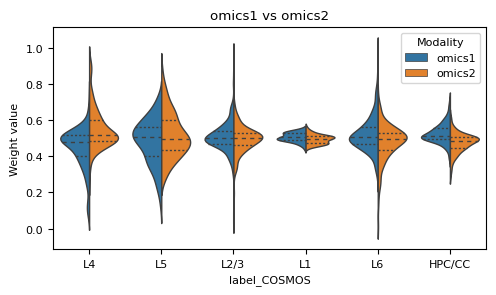

In [9]:
def plot_weight_value(alpha, label, modality1='omics1', modality2='omics2',order = None):
    df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
    df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
    df['label'] = label
    df = df.set_index('label').stack().reset_index()
    df.columns = ['label_COSMOS', 'Modality', 'Weight value']
    matplotlib.rcParams['font.size'] = 8.0
    fig, axes = plt.subplots(1, 1, figsize=(5,3))
    ax = sns.violinplot(data=df, x='label_COSMOS', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1, show=False, orient = 'v', order=order)
    ax.set_title(modality1 + ' vs ' + modality2) 
    plt.tight_layout(w_pad=0.05)

weights = cosmos_comb.weights
df_wghts = pd.DataFrame(weights,columns = ['w1','w2'])
weights = np.array(df_wghts)
for k in range(1,len(label_type)):
    wghts_mean = np.mean(weights[index_all[0],:],0)
for k in range(1,len(label_type)):
    wghts_mean_temp = np.mean(weights[index_all[k],:],0)
    wghts_mean = np.vstack([wghts_mean, wghts_mean_temp])
df_wghts_mean = pd.DataFrame(wghts_mean,columns = ['w1','w2'],index = label_type)
df_sort_mean = df_wghts_mean.sort_values(by=['w1'])
plot_weight_value(np.array(df_wghts), np.array(adata.obs['LayerName']), order = list(df_sort_mean.index))